In [1]:
import sys
sys.path.append("F:/skripsi/FAS-Skripsi-4")

from fas_simple_distill.model.resnet_ssdg.ssdg_resnet_decoder_no_relu import Dec_model
from face_detection import FaceDetection, FaceSelectionMethod
from torchvision.transforms import ToTensor, Normalize, Resize
import cv2
import numpy as np
from PIL import Image
import ipyplot
import torch

sys.path.remove("F:/skripsi/FAS-Skripsi-4")

In [2]:
class crop_align_face:
    def __init__(
        self,
        use_cuda: bool = True,
        no_rotate: bool = True,
        crop_size: int = 256,
        scale: float = 0.75,
        select_method = FaceSelectionMethod.AREA,
    ) -> None:
        use_onnx = not use_cuda
        self.fd = FaceDetection(use_cuda, no_rotate, use_onnx)
        self.crop_size = crop_size
        self.scale = scale
        self.select_method = select_method

    def __call__(self, x):
        if isinstance(x, Image.Image):
            input_is_pil = True
            x = np.array(x)
            x = cv2.cvtColor(x, cv2.COLOR_RGB2BGR)
        else:
            input_is_pil = False
        
        dets, angle = self.fd.predict(x)
        x_crop, _ = self.fd.align_single_face(x, dets, angle, self.crop_size, self.scale, self.select_method)

        if input_is_pil:
            x_crop = cv2.cvtColor(x_crop, cv2.COLOR_BGR2RGB)
            x_crop = Image.fromarray(x_crop)
        
        return x_crop

_resize = Resize(112)

_crop_face = crop_align_face()
_to_tensor = ToTensor()
_normalize = Normalize(
    # mean=[0.485, 0.456, 0.406],
    # std=[0.229, 0.224, 0.225],
    mean=[0.5, 0.5, 0.5],
    std=[0.5, 0.5, 0.5],
)

def _preprocess_data(image: np.ndarray) -> np.ndarray:
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    processed_data = Image.fromarray(rgb_image)
    processed_data = _crop_face(processed_data)
    processed_data = _to_tensor(processed_data)
    processed_data = _normalize(processed_data)
    return processed_data.unsqueeze(0)

In [3]:
test_data = "F:/skripsi/FAS-Skripsi-4/casia_mfsd/train/1/live/1_1_0.png"
pretrained_path = "F:/skripsi/FAS-Skripsi-4/evaluator/weights/ssdg_decoder_FAS_MSELoss_no_relu_OMItoC.pth"

(256, 256, 3)



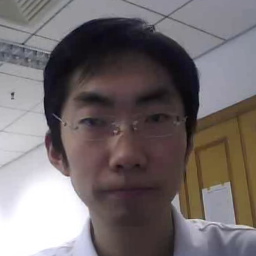
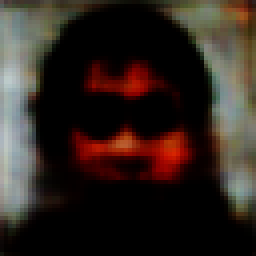


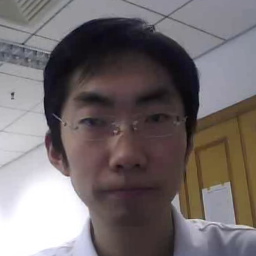
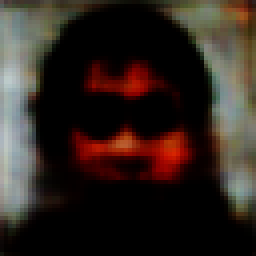

In [4]:
dec_model = Dec_model(
    "resnet18",
    "r18",
    512,
    0.0,
    norm_flag=True
)

ckpt = torch.load(pretrained_path)
model_ckpt = ckpt["model"]

dec_model.load_state_dict(model_ckpt)

img = cv2.imread(test_data)
aligned_img = _crop_face(img)
img = _preprocess_data(img)
resized_img = _resize(img)

_, _, _, recon_img = dec_model(img, resized_img)

recon_img = recon_img.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)
# recon_img = cv2.cvtColor(recon_img, cv2.COLOR_RGB2BGR)
aligned_img = cv2.cvtColor(aligned_img, cv2.COLOR_BGR2RGB)

print(recon_img.shape)
ipyplot.plot_images([aligned_img, recon_img], ["Original Image", "Reconstructed Image"])
